In [1]:
import findspark
findspark.init()

import pyspark.sql.functions as F

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

from etl import SparkETL
from dim import RouteDim, VisitorDim

In [2]:
etl = SparkETL()
spark = etl.get_spark()
visitor_helper = VisitorDim()

22/05/13 20:43:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
immigration = etl.read_clean_table('immigration')

In [4]:
def aggregates(df):
    return (
        df
        .withColumn('day', F.expr("DAY(arrival_date)"))
        .groupby(
            'arrival_date', # time_dim nk
            *(RouteDim().get_nk()),
            *(visitor_helper.get_nk())
        )
        .agg(
            F.count('count').alias('num_visitors'),
            F.avg('age').alias('age_avg'),
            F.stddev('age').alias('age_std'),
            F.avg('stay').alias('stay_avg'),
            F.stddev('stay').alias('stay_std'),
        )
    )

In [5]:
def replace_null(colname, value):
    return F.expr(f"""
            IF(
                {colname} IS NULL,
                {value},
                {colname}
            )
            """)



In [6]:
def replace_null_stddev(df, colname):
    return df.withColumn(
        colname,
        replace_null(colname, 0.0)
    )

In [7]:
def project_time_sk(df):
    
    time_dim = etl.read_dim_table('time_dim')
    
    return (
        df
        .join(
            time_dim.select('time_id', 'date'),
            on=df['arrival_date'] == time_dim['date'],
            how='inner'
        )
        .drop('arrival_date', 'date')
    )

In [8]:
def project_route_sk(df):
    
    route_dim = etl.read_dim_table('route_dim')
    
    return (
        df
        .join(
            route_dim.select('route_id', 'airline', 'flight_number', 'port_id'),
            on=(
                (df['airline'] == route_dim['airline'])
                & (df['flight_number'] == route_dim['flight_number'])
                & (df['port_id'] == route_dim['port_id'])
            ),
            how='inner'
        )
        .drop('airline', 'flight_number', 'port_id')
    )

In [9]:
def project_visitor_sk(df):
    
    visitor_dim = etl.read_dim_table('foreign_visitor_dim')
    
    return (
        df
        .join(
            visitor_dim.select('visitor_id', *(visitor_helper.get_nk())),
            visitor_helper.on_nk(df, visitor_dim),
            'inner'
        )
        .drop(*(visitor_helper.get_nk()))
    )

In [10]:
def project_schema(df):
    
    column_order = ['time_id', 'route_id', 'visitor_id', 'num_visitors', 'age_avg', 'age_std', 'stay_avg', 'stay_std']
    
    return df.select(*column_order)

In [11]:
def print_count(df):
    print("%.6f" % (df.count() / 1e3))
    return df

In [12]:
def flight_fact(df, date):
    return (
        df
        .pipe(SparkETL.filter_one_month, date)
        #.pipe(lambda df: df.where(F.col('day') == 1))
        .pipe(aggregates)
        #.pipe(replace_null_stddev, 'age_std')
        #.pipe(replace_null_stddev, 'stay_std')
        .pipe(project_time_sk)
        .pipe(project_route_sk)
        .pipe(project_visitor_sk)
        #.pipe(print_count)
        .pipe(project_schema)
    )

In [42]:
etl.save_fact_table(
    immigration.pipe(flight_fact),
    'flight_fact',
)

22/05/13 16:23:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 16:23:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 16:23:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 16:23:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 16:23:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 16:23:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 16:23:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 16:23:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 16:23:13 WARN RowBasedKeyValueBatch: Calling spill() on

In [32]:
from datetime import datetime

for month in range(1,13):
    date = f"2016-{month:02d}-01"
    print(date)
    etl.save_fact_table(
        immigration.pipe(flight_fact, date),
        'flight_fact',
    )

2016-01-01


22/05/13 19:32:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:19 WARN RowBasedKeyValueBatch: Calling spill() on

2016-02-01


22/05/13 19:32:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


2016-03-01


22/05/13 19:32:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:37 WARN RowBasedKeyValueBatch: Calling spill() on

2016-04-01


22/05/13 19:32:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:46 WARN RowBasedKeyValueBatch: Calling spill() on

2016-05-01


22/05/13 19:32:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:32:55 WARN RowBasedKeyValueBatch: Calling spill() on

2016-06-01
2016-07-01


22/05/13 19:33:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:04 WARN RowBasedKeyValueBatch: Calling spill() on

2016-08-01


22/05/13 19:33:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:14 WARN RowBasedKeyValueBatch: Calling spill() on

2016-09-01


22/05/13 19:33:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


2016-10-01


22/05/13 19:33:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:31 WARN RowBasedKeyValueBatch: Calling spill() on

2016-11-01


22/05/13 19:33:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:39 WARN RowBasedKeyValueBatch: Calling spill() on

2016-12-01


22/05/13 19:33:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 19:33:46 WARN RowBasedKeyValueBatch: Calling spill() on

In [19]:
flight = etl.read_fact_table('flight_fact')

In [15]:
flight.count()

21340695

In [35]:
flight.count() == flight.drop_duplicates().count()

[191.808s][warning][gc,alloc] Executor task launch worker for task 8.0 in stage 114.0 (TID 737): Retried waiting for GCLocker too often allocating 262146 words
[191.818s][warning][gc,alloc] Executor task launch worker for task 1.0 in stage 114.0 (TID 730): Retried waiting for GCLocker too often allocating 262146 words
[191.829s][warning][gc,alloc] Executor task launch worker for task 8.0 in stage 114.0 (TID 737): Retried waiting for GCLocker too often allocating 262146 words
[191.829s][warning][gc,alloc] Executor task launch worker for task 1.0 in stage 114.0 (TID 730): Retried waiting for GCLocker too often allocating 262146 words
[191.838s][warning][gc,alloc] Executor task launch worker for task 1.0 in stage 114.0 (TID 730): Retried waiting for GCLocker too often allocating 262146 words
[191.838s][warning][gc,alloc] Executor task launch worker for task 8.0 in stage 114.0 (TID 737): Retried waiting for GCLocker too often allocating 262146 words


22/05/13 19:34:24 WARN TaskMemoryManager: Failed to allocate a page (2097152 bytes), try again.
22/05/13 19:34:24 WARN TaskMemoryManager: Failed to allocate a page (2097152 bytes), try again.
22/05/13 19:34:24 WARN TaskMemoryManager: Failed to allocate a page (2097152 bytes), try again.
22/05/13 19:34:24 WARN TaskMemoryManager: Failed to allocate a page (2097152 bytes), try again.
22/05/13 19:34:24 WARN TaskMemoryManager: Failed to allocate a page (2097152 bytes), try again.
22/05/13 19:34:24 WARN TaskMemoryManager: Failed to allocate a page (2097152 bytes), try again.


[192.869s][warning][gc,alloc] Executor task launch worker for task 3.0 in stage 114.0 (TID 732): Retried waiting for GCLocker too often allocating 131074 words


22/05/13 19:34:25 ERROR Executor: Exception in task 3.0 in stage 114.0 (TID 732)
java.lang.OutOfMemoryError: Java heap space
22/05/13 19:34:25 ERROR SparkUncaughtExceptionHandler: Uncaught exception in thread Thread[Executor task launch worker for task 3.0 in stage 114.0 (TID 732),5,main]
java.lang.OutOfMemoryError: Java heap space
22/05/13 19:34:25 ERROR Inbox: Ignoring error
java.util.concurrent.RejectedExecutionException: Task org.apache.spark.executor.Executor$TaskRunner@16270d9b rejected from java.util.concurrent.ThreadPoolExecutor@6cd35a11[Shutting down, pool size = 12, active threads = 12, queued tasks = 0, completed tasks = 729]
	at java.base/java.util.concurrent.ThreadPoolExecutor$AbortPolicy.rejectedExecution(ThreadPoolExecutor.java:2055)
	at java.base/java.util.concurrent.ThreadPoolExecutor.reject(ThreadPoolExecutor.java:825)
	at java.base/java.util.concurrent.ThreadPoolExecutor.execute(ThreadPoolExecutor.java:1355)
	at org.apache.spark.executor.Executor.launchTask(Executor.

Py4JJavaError: An error occurred while calling o1782.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 114.0 failed 1 times, most recent failure: Lost task 3.0 in stage 114.0 (TID 732) (192.168.1.43 executor driver): java.lang.OutOfMemoryError: Java heap space

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2261)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:390)
	at org.apache.spark.sql.Dataset.$anonfun$count$1(Dataset.scala:3006)
	at org.apache.spark.sql.Dataset.$anonfun$count$1$adapted(Dataset.scala:3005)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.count(Dataset.scala:3005)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.lang.OutOfMemoryError: Java heap space


In [20]:
import pandas as pd
pd.set_option('display.max_rows', 2000)

In [21]:
flight.limit(1000).toPandas()

,time_id,route_id,visitor_id,num_visitors,age_avg,age_std,stay_avg,stay_std
0,84d40dff0ac0a8b9d9071d89d6f10d2b,2687a2321046ad1a0bb810e7651543e8,7e9b88cb73e4090ecbde271591ba51b5,2,6.000000,0.000000,3.000000,0.000000
1,eb826e826f8de8f025202ed50a021b00,866ce0b55e6702b4d998513d3cd72549,7e9b88cb73e4090ecbde271591ba51b5,2,6.000000,0.000000,6.000000,0.000000
2,fae5d034d4201c6e1cabd10761752906,28211e657da6a88d98216333b349bfc4,e75a25042869fcd05d59b8121b5fab75,2,2.000000,0.000000,7.000000,0.000000
3,c19c98e9a2b2e7006acacb2816f441a7,520148273b1b5704111b394923adfb77,c0f766c714976ae286c8c58f0f226645,2,6.000000,0.000000,16.000000,0.000000
4,fae5d034d4201c6e1cabd10761752906,6b69697481c32aa725bab7bdf9ec8c2f,8b2ce6ff86acca60b86035f00aad2f15,2,3.000000,0.000000,17.000000,0.000000
5,99e61a5d57a3b96115c0ec6b5331fb04,4717772b7a89f604d317672048ef9026,71a4f5c7ad2dd26f2062a3f55f5637c7,2,5.000000,0.000000,42.000000,0.000000
6,83f663d66232c019b16c17600466dfcd,47fff473ff5ea1db889e52b3a7b7f857,bea50339bd3173c1b8acb78c6c7a8776,2,19.000000,0.000000,8.000000,0.000000
7,c01aaaf46d6c5818c911b38d45d9a9a9,407321022fe253ae9d957a0c8cc901c8,88602dd14de85fd8e834a1f5aea1e585,2,18.000000,0.000000,6.000000,0.000000
8,fae5d034d4201c6e1cabd10761752906,28211e657da6a88d98216333b349bfc4,88602dd14de85fd8e834a1f5aea1e585,4,20.000000,2.309401,7.000000,0.000000
9,83f663d66232c019b16c17600466dfcd,47fff473ff5ea1db889e52b3a7b7f857,affb66e3167b3b51082d40483e9bc2d4,2,18.000000,0.000000,8.000000,0.000000


In [22]:
from dim import TimeDim, VisitorDim, RouteDim, Dim

In [23]:
time_dim = TimeDim()
visitor_helper = VisitorDim()
route_helper = RouteDim()

In [24]:
def group(df, cols):
    return (
        df
        .groupby(*cols)
        .agg(
            F.sum('num_visitors').alias('count')
        )
    )

In [25]:
def join_dim(df, name, pk, cols=None):
    keys = cols if cols else [pk]
    dim = etl.read_dim_table(name)
    return (
        df.join(dim, on=Dim.on(df, dim, keys), how='inner')
    )    

In [26]:
def project_desc(df):
    return df.select(
        'count', 
        'citizenship', 
        'residence', 
        'age', 
        'gender', 
        'visa', 
        'address_state', 
        'address_type', 
        'address_climate', 
        'stay')

In [27]:
def plot(df, col):
    display(
        df
        .limit(20)
        .toPandas()
        .plot(x=col, y='count', kind='barh')
    )
    return df

In [122]:
def scatter(df):
    df.toPandas().plot(x=cols[-1], y='count', kind='scatter')

In [28]:
def sort_count(df):
    return df.sort(F.desc('count'))

In [68]:
def where(df, cond):
    return df.where(cond)# if cond else df

In [139]:
cols = ['residence', 'age']

In [78]:
cond = F.col('residence') != F.col('citizenship')

22/05/13 22:10:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 22:10:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 22:10:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 22:10:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 22:10:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 22:10:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 22:10:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 22:10:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/13 22:10:30 WARN RowBasedKeyValueBatch: Calling spill() on

<AxesSubplot:ylabel='age'>

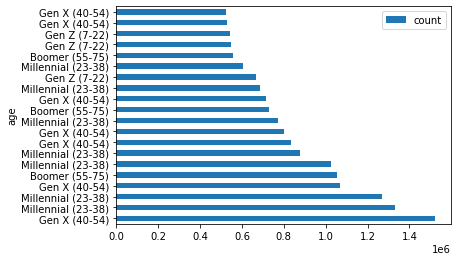

In [141]:
(
    flight
    #.pipe(join_dim, 'time_dim', 'time_id')
    #.pipe(join_dim, 'route_dim', 'route_id')
    .pipe(join_dim, 'foreign_visitor_dim', 'visitor_id')
    #.pipe(where, cond)
    #.pipe(project_desc)
    .pipe(group, cols)
    .pipe(sort_count)
    .pipe(plot, cols[1])
    #.pipe(scatter)
    #.pipe(lambda df: display(df.limit(1000).toPandas()))
);

In [88]:
etl.read_clean_table('immigration').count()

41810230

In [94]:
#validation: sum of all partial sums equals immigration count
(
    flight.select('num_visitors').agg(F.sum('num_visitors')).show()
    == 
    etl.read_clean_table('immigration').count()
)

+-----------------+
|sum(num_visitors)|
+-----------------+
|         41810230|
+-----------------+



False

In [115]:
# TODO: cleaning demographics, Hawai missing, a very important destination
etl.read_clean_table('port').where(F.col('port_id') == 'HHW').show()

+-------+--------+--------+
|port_id|state_id|    name|
+-------+--------+--------+
|    HHW|      HI|HONOLULU|
+-------+--------+--------+

